# ***TIME SERIES ANALYSIS***

---



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams['figure.figsize'] = (15,7)

from statsmodels.graphics.tsaplots import month_plot,quarter_plot

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [1]:
from google.colab import files
  
  
uploaded = files.upload()

ModuleNotFoundError: No module named 'google'

In [ ]:
df = pd.read_csv('bitcoin_final.csv', index_col= 'timestamp', parse_dates= True)
df.index.freq = 'H'
df.head()

,close,volume,trades
timestamp,,,
2017-01-01 00:00:00+00:00,968.29,392573,94
2017-01-01 01:00:00+00:00,968.00,384541,132
2017-01-01 02:00:00+00:00,963.40,355937,122
2017-01-01 03:00:00+00:00,964.26,160422,43
2017-01-01 04:00:00+00:00,961.69,286675,65


**SEASONAL DECOMPOSITION**

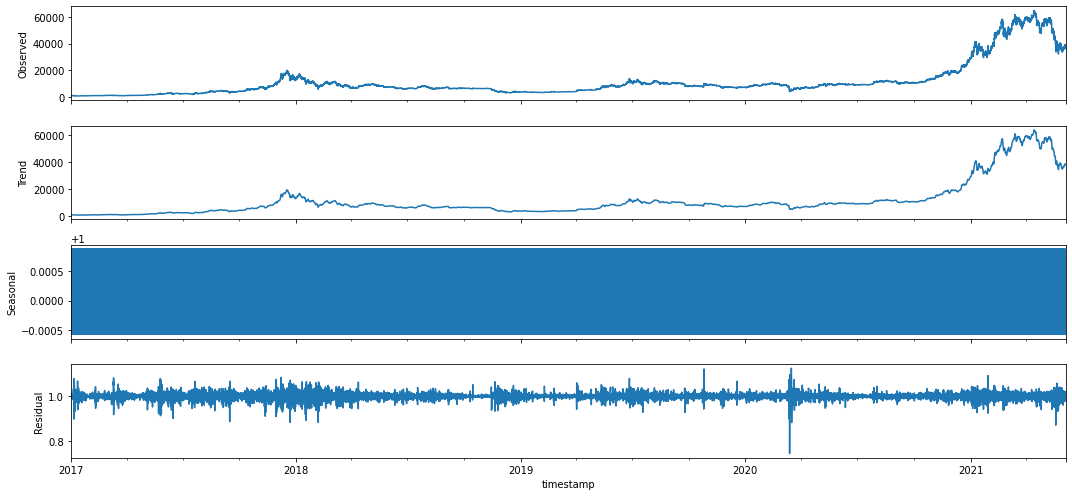

In [ ]:
result = seasonal_decompose(df['close'], model= 'mul')
result.plot();

### The plot of Seasonality is a rectangle as there is so much variation so it seems Seasonality is not there.

**TREND COMPONENT**

*MOVING AVERAGE*

In [ ]:
df['30-Day Moving Average'] = df['close'].rolling(window=(24*30)).mean()

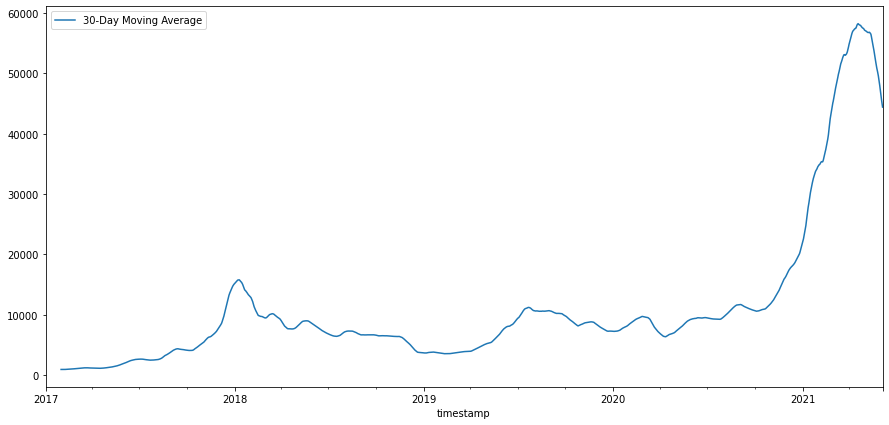

In [ ]:
df['30-Day Moving Average'].plot()
plt.legend()
plt.show();
# So Definitely there is an Increasing Trend.

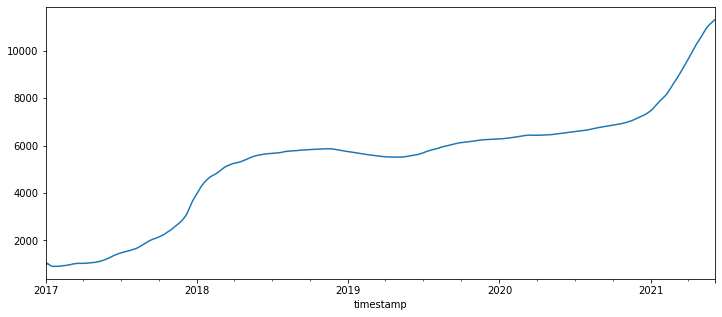

In [ ]:
df['close'].expanding().mean().plot(figsize=(12,5));
 #It is giving us a smooth function graph corresponding to our price data

# EWMA
## Exponentially Weighted Moving Average 

We just showed how to calculate the SMA based on some window. However, basic SMA has some weaknesses:
* Smaller windows will lead to more noise, rather than signal
* It will always lag by the size of the window
* It will never reach to full peak or valley of the data due to the averaging.
* Does not really inform you about possible future behavior, all it really does is describe trends in your data.
* Extreme historical values can skew your SMA significantly

To help fix some of these issues, we can use an <a href='https://en.wikipedia.org/wiki/Exponential_smoothing'>EWMA (Exponentially weighted moving average)</a>.

In [ ]:
df['30-Day EWM'] = df['close'].ewm(span=(24*30)).mean()

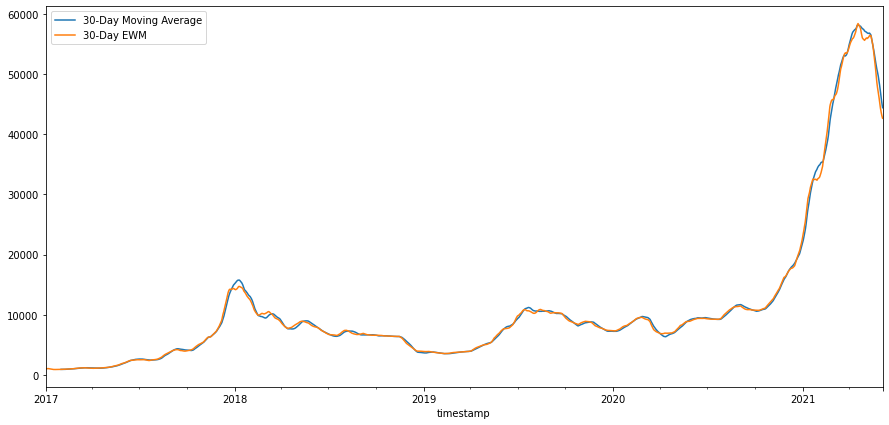

In [ ]:
df[['30-Day Moving Average', '30-Day EWM']].plot()
plt.legend()
plt.show();
# So Simple Moving Average and EWMA are almost similar showing an Increasing Trend.

# MODEL BUILDING

### Our First Requirement is Stationarity We knows that our Prices are not Stationary. Lets test it and do Differencing to make it Stationary


In [ ]:
# We will use adfuller test for Stationarity and lets make a function
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
adf_test(df['close'], title = 'Bitcoin Prices')

Augmented Dickey-Fuller Test: Bitcoin Prices
ADF test statistic         -0.425902
p-value                     0.905683
# lags used                54.000000
# observations          38717.000000
critical value (1%)        -3.430519
critical value (5%)        -2.861615
critical value (10%)       -2.566810
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


*So Definutely Our Prices are not Stationary*

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

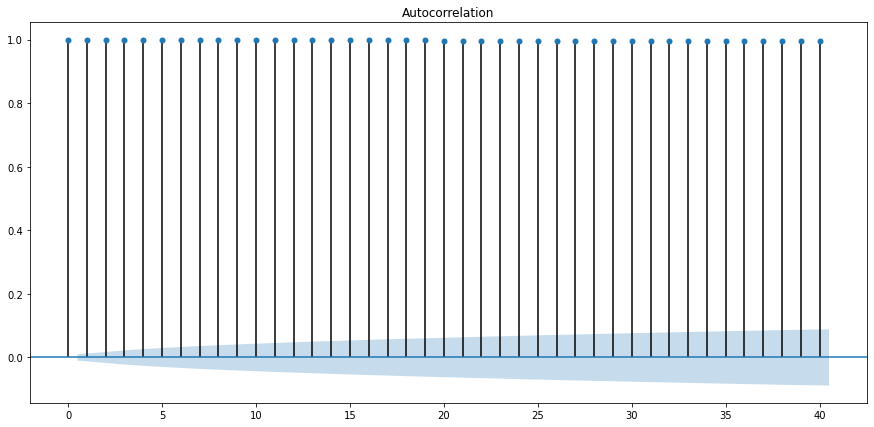

In [ ]:
plot_acf(df['close'], lags = 40);


*It is Also Evident From ACF Plot It is not Showing a Decreasing Nature with lags so Differencing is Required*

In [ ]:
from statsmodels.tsa.statespace.tools import diff

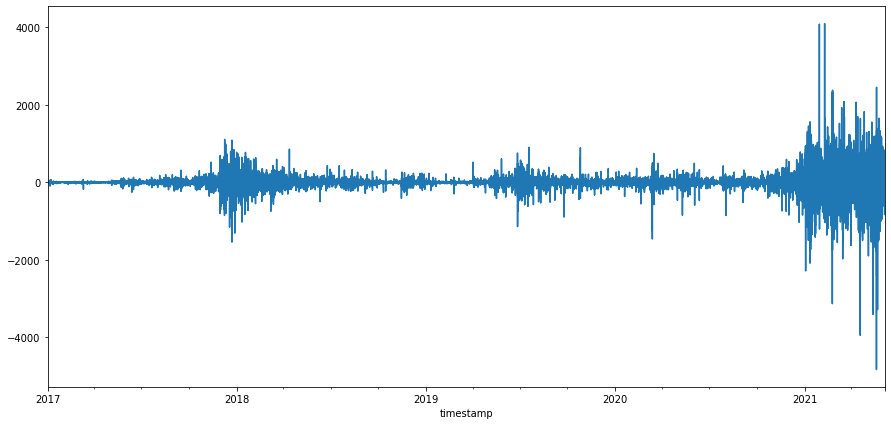

In [ ]:
df['close_1diff'] = diff(df['close'],k_diff=1)
df['close_1diff'].plot();


 We can Observe that mean is Constant but Variance is not Let's test it Formally

In [ ]:
print(adf_test(df['close_1diff'], title= '1st Difference of Bitcoin Prices'))

Augmented Dickey-Fuller Test: 1st Difference of Bitcoin Prices
ADF test statistic        -27.950746
p-value                     0.000000
# lags used                53.000000
# observations          38717.000000
critical value (1%)        -3.430519
critical value (5%)        -2.861615
critical value (10%)       -2.566810
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
None


Great!! Data becomes Stationary after Differencing Once but, We can't say that this is best order of Differencing we need to check Further.

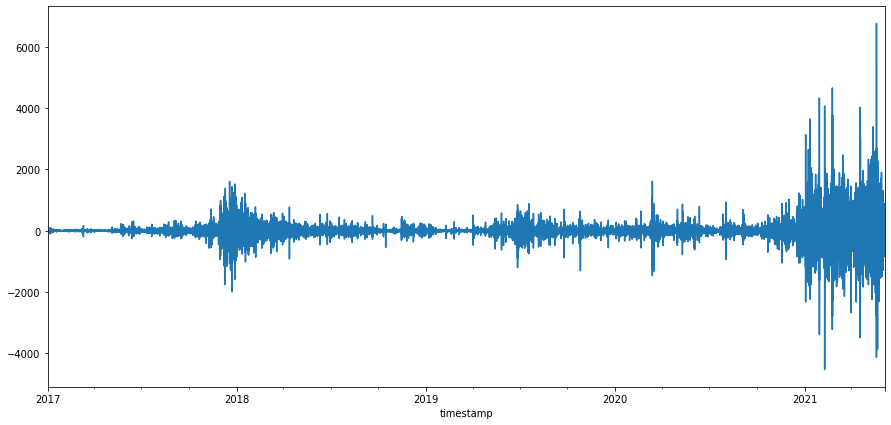

In [ ]:
df['close_2diff'] = diff(df['close'],k_diff=2)
df['close_2diff'].plot();

In [ ]:
print(adf_test(df['close_2diff'], title= '2nd Difference of Bitcoin Prices'))

Augmented Dickey-Fuller Test: 2nd Difference of Bitcoin Prices
ADF test statistic        -47.051603
p-value                     0.000000
# lags used                54.000000
# observations          38715.000000
critical value (1%)        -3.430519
critical value (5%)        -2.861615
critical value (10%)       -2.566810
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
None


2nd Difference also comes out to be Stationary So the Question is Which one to Choose

## Identifying the order of differencing in an ARIMA model

Rule 1: If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing.

Rule 2: If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of  differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.  BEWARE OF OVERDIFFERENCING!!

Rule 3: The optimal order of differencing is often the order of differencing at which the standard deviation is lowest.


In [ ]:
print("The Standard-Deviation of 1st Difference is: ",np.std(df['close_1diff'][1:]))
print("The Standard-Deviation of 2nd Difference is: ",np.std(df['close_2diff'][2:]))

The Standard-Deviation of 1st Difference is:  172.89442512231525
The Standard-Deviation of 2nd Difference is:  246.9136780874776


**So 1st differences have lower Standard Error**

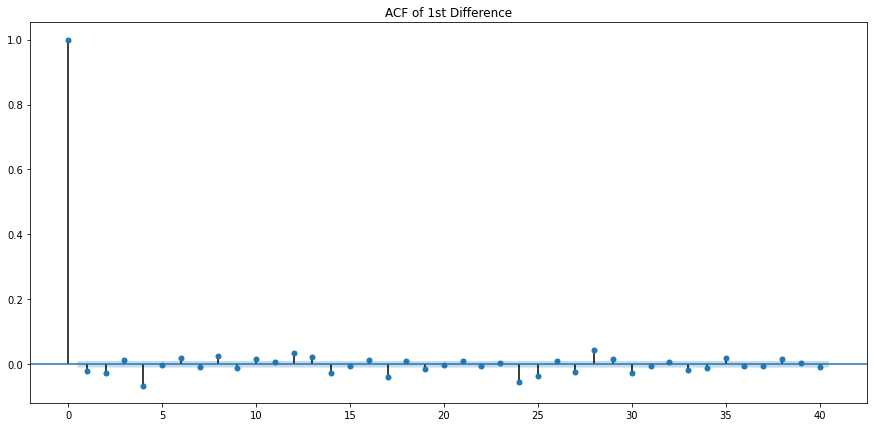

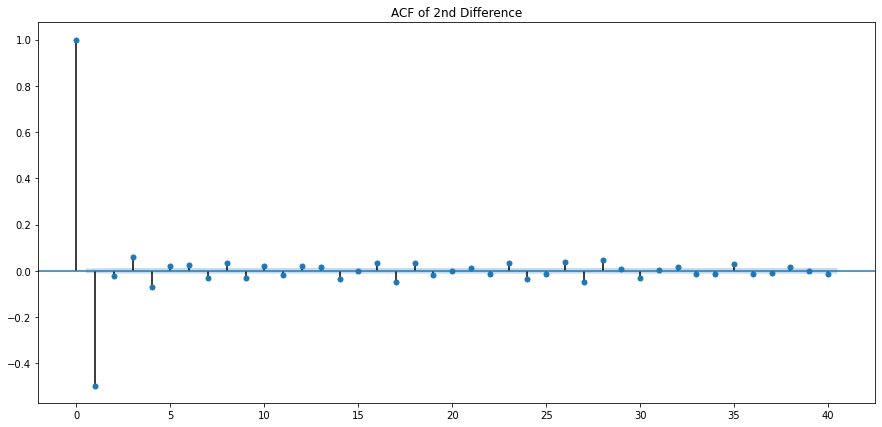

In [ ]:
plot_acf(df['close_1diff'][1:], lags=40, title= 'ACF of 1st Difference')
plot_acf(df['close_2diff'][2:], lags=40, title= 'ACF of 2nd Difference');


*We can Observe that in 2nd order Differencing the 1st lag Autocorrelation is highly negative so We might be Over-Differencing also The Standard error of 2nd difference is greater than that of 1st Difference so 1st order Differencing is more Apt*

In [ ]:
del df['close_2diff']

ACF AND PACF PLOTS OF 1st Difference

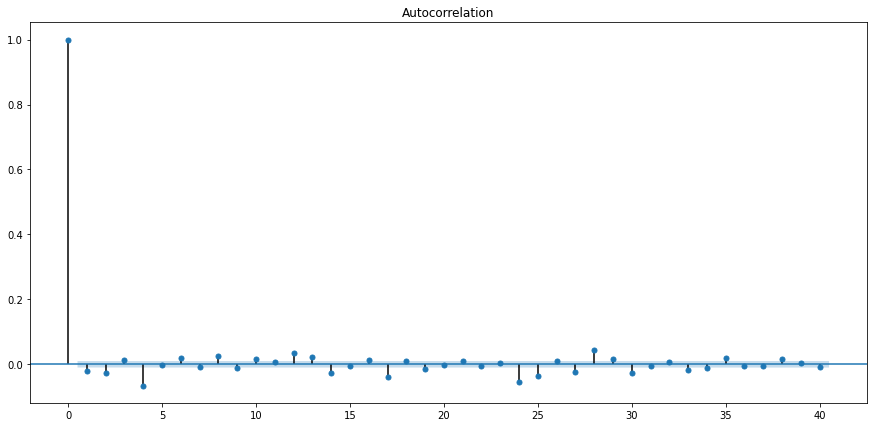

In [ ]:
plot_acf(df['close_1diff'][1:],lags=40);

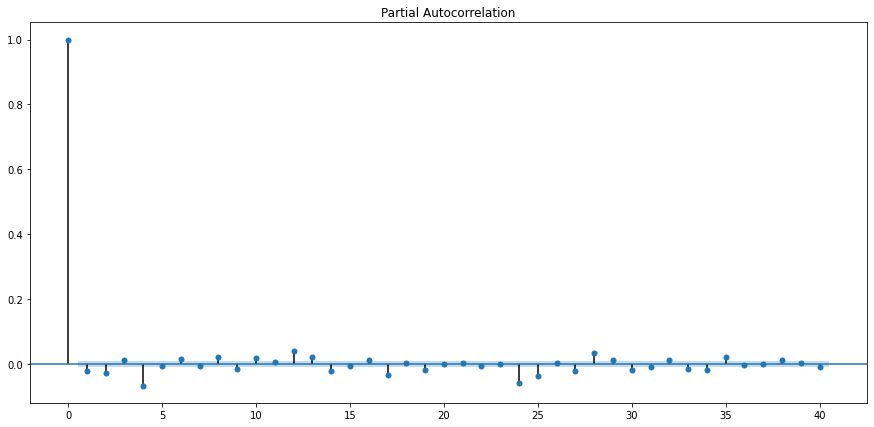

In [ ]:
plot_pacf(df['close_1diff'][1:],lags=40);

## From ACF and PACF plots it is difficult to choose order of AR and MA but It is evident that we can take both upto 4 order.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2
#LLR TEST
def LLR_test(mod_1,mod_2, DF=1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR,DF).round(5)
    return p

In [ ]:
train = df[:'2021-04-30']['close']
test = df['2021-05-01':]['close']

Lets Start with (6,1,6) model then we will try to reduce the Parameters and choose that model with Lowest Test MSE, Highest Log-Likelihood and Low AIC and BIC

In [ ]:
model_616_ = ARIMA(train, order=(6,1,6), freq='H').fit()
print(model_616_.summary())


                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                37943
Model:                 ARIMA(6, 1, 6)   Log Likelihood             -244612.062
Method:                       css-mle   S.D. of innovations            152.610
Date:                Sat, 12 Jun 2021   AIC                         489252.124
Time:                        08:57:35   BIC                         489371.737
Sample:                    01-01-2017   HQIC                        489290.079
                         - 04-30-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.4827      0.785      1.888      0.059      -0.057       3.022
ar.L1.D.close     1.1103      0.011    101.169      0.000       1.089       1.132
ar.L2.D.close    -0.3584      0.019    -

In [51]:
from sklearn.metrics import mean_squared_error

In [50]:
model_616 = ARIMA(train, order=(6,1,6)).fit()
print(model_616.summary())

start=len(train)
end=len(train)+len(test)-1
predictions_616 = model_616.predict(start=start, end=end,typ = 'levels').rename('ARMA(6,1,6) Predictions')
fitted_values_616 = model_616.predict(start = 1, end= len(train) - 1,typ= 'levels').rename('Fiited Values of ARIMA(6,1,6)')



                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                37943
Model:                 ARIMA(6, 1, 6)   Log Likelihood             -244612.062
Method:                       css-mle   S.D. of innovations            152.610
Date:                Sat, 12 Jun 2021   AIC                         489252.124
Time:                        09:23:40   BIC                         489371.737
Sample:                    01-01-2017   HQIC                        489290.079
                         - 04-30-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.4827      0.785      1.888      0.059      -0.057       3.022
ar.L1.D.close     1.1103      0.011    101.169      0.000       1.089       1.132
ar.L2.D.close    -0.3584      0.019    -

NameError: ignored

In [52]:
np.sqrt(mean_squared_error(test,predictions_616))

15050.679387359018

In [53]:
model_516 = ARIMA(train, order=(5,1,6)).fit()
print(model_516.summary())

start=len(train)
end=len(train)+len(test)-1
predictions_516 = model_516.predict(start=start, end=end,typ = 'levels').rename('ARMA(5,1,6) Predictions')
fitted_values_516 = model_516.predict(start = 1, end= len(train) - 1,typ= 'levels').rename('Fiited Values of ARIMA(5,1,6)')

np.sqrt(mean_squared_error(test,predictions_516))

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                37943
Model:                 ARIMA(5, 1, 6)   Log Likelihood             -244646.218
Method:                       css-mle   S.D. of innovations            152.748
Date:                Sat, 12 Jun 2021   AIC                         489318.435
Time:                        09:26:34   BIC                         489429.505
Sample:                    01-01-2017   HQIC                        489353.679
                         - 04-30-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.4819      0.747      1.983      0.047       0.018       2.946
ar.L1.D.close    -1.0891      0.150     -7.272      0.000      -1.383      -0.796
ar.L2.D.close    -1.0454      0.142     

15002.150840046299

In [54]:
LLR_test(model_516,model_616)


0.0

**In Test Error Model 5,1,5 is better but in Log Likelihood 6,1,6 is better It is possible that 6,1,6 is Overfitting. So, lets reduce the Order**

In [55]:
model_515 = ARIMA(train, order=(5,1,5)).fit()
print(model_515.summary())

start=len(train)
end=len(train)+len(test)-1
predictions_515 = model_515.predict(start=start, end=end,typ = 'levels').rename('ARMA(5,1,5) Predictions')
fitted_values_515 = model_515.predict(start = 1, end= len(train) - 1,typ= 'levels').rename('Fiited Values of ARIMA(5,1,5)')

print(np.sqrt(mean_squared_error(test,predictions_515)))
LLR_test(model_515,model_616)


                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                37943
Model:                 ARIMA(5, 1, 5)   Log Likelihood             -244651.236
Method:                       css-mle   S.D. of innovations            152.768
Date:                Sat, 12 Jun 2021   AIC                         489326.473
Time:                        09:35:32   BIC                         489428.999
Sample:                    01-01-2017   HQIC                        489359.006
                         - 04-30-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.4813      0.739      2.005      0.045       0.033       2.929
ar.L1.D.close    -0.1585      0.085     -1.868      0.062      -0.325       0.008
ar.L2.D.close    -0.3762      0.065     

0.0

In [56]:
LLR_test(model_515,model_516)

0.00153

In [57]:
model_414 = ARIMA(train, order=(4,1,4)).fit()
print(model_414.summary())

start=len(train)
end=len(train)+len(test)-1
predictions_414 = model_414.predict(start=start, end=end,typ = 'levels').rename('ARMA(4,1,4) Predictions')
fitted_values_414 = model_414.predict(start = 1, end= len(train) - 1,typ= 'levels').rename('Fiited Values of ARIMA(4,1,4)')

print(np.sqrt(mean_squared_error(test,predictions_414)))
LLR_test(model_414,model_616, DF=4)

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                37943
Model:                 ARIMA(4, 1, 4)   Log Likelihood             -244630.917
Method:                       css-mle   S.D. of innovations            152.686
Date:                Sat, 12 Jun 2021   AIC                         489281.833
Time:                        09:42:06   BIC                         489367.272
Sample:                    01-01-2017   HQIC                        489308.944
                         - 04-30-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.4791      0.783      1.889      0.059      -0.056       3.014
ar.L1.D.close     0.4205      0.011     39.649      0.000       0.400       0.441
ar.L2.D.close     0.9238      0.013     

0.0

In [62]:
LLR_test(model_414,model_516, DF=3)

1.0

In [58]:
model_212 = ARIMA(train, order=(2,1,2)).fit()
print(model_212.summary())

start=len(train)
end=len(train)+len(test)-1
predictions_212 = model_212.predict(start=start, end=end,typ = 'levels').rename('ARMA(2,1,2) Predictions')
fitted_values_212 = model_212.predict(start = 1, end= len(train) - 1,typ= 'levels').rename('Fiited Values of ARIMA(2,1,2)')

print(np.sqrt(mean_squared_error(test,predictions_212)))
LLR_test(model_212,model_616, DF=8)

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                37943
Model:                 ARIMA(2, 1, 2)   Log Likelihood             -244679.009
Method:                       css-mle   S.D. of innovations            152.880
Date:                Sat, 12 Jun 2021   AIC                         489370.018
Time:                        09:44:59   BIC                         489421.281
Sample:                    01-01-2017   HQIC                        489386.284
                         - 04-30-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.4810      0.776      1.909      0.056      -0.040       3.002
ar.L1.D.close    -1.4797      0.010   -149.317      0.000      -1.499      -1.460
ar.L2.D.close    -0.9322      0.012    -

0.0

In [63]:
LLR_test(model_212,model_516, DF=7)


0.0

## The Least MSE is in Model 5,1,6 so we will choose that

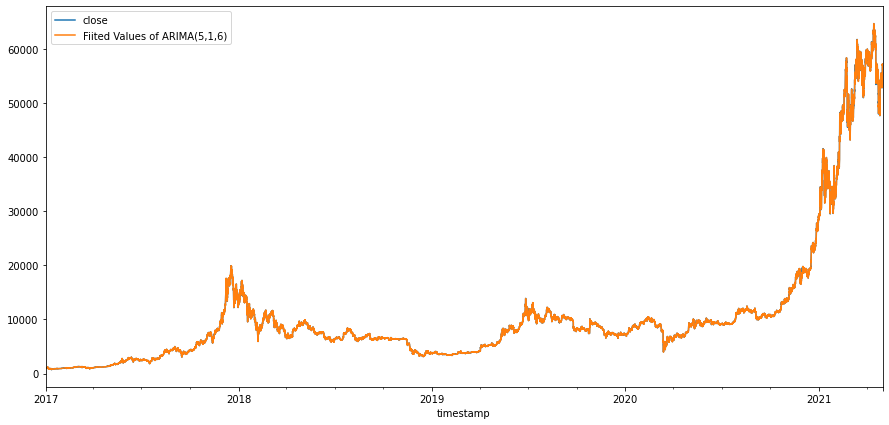

In [67]:
train.plot(legend = True)
fitted_values_516.plot(legend = True)

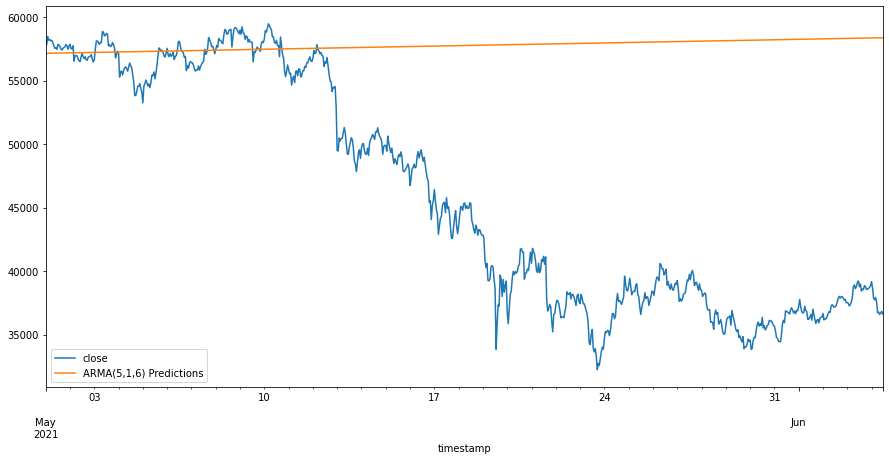

In [66]:
test.plot(legend = True)
predictions_516.plot(legend = True)

# ***MULTIVARIATE TIME SERIES***
We will use Volume as our Exogeneous Variable

In [68]:
X_train = df[:'2021-04-30']['volume']
X_test = df['2021-05-01':]['volume']
y_train = df[:'2021-04-30']['close']
y_test = df['2021-05-01':]['close']

Lets choose Previous best model

In [69]:
model_516_ = ARIMA(y_train, order=(5,1,6),exog= X_train).fit()
print(model_516_.summary())

start=len(train)
end=len(train)+len(test)-1
predictions_516_ = model_516_.predict(start=start, end=end,typ = 'levels',exog= X_test).rename('ARMA(4,1,5) exog Predictions')
fitted_values_516_ = model_516_.predict(start = 1, end= len(train) - 1,typ= 'levels', exog= X_train).rename('Fiited Values ARIMA(5,1,6) exog')

np.sqrt(mean_squared_error(y_test,predictions_516_))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                37943
Model:                 ARIMA(5, 1, 6)   Log Likelihood             -244669.427
Method:                       css-mle   S.D. of innovations            152.842
Date:                Sat, 12 Jun 2021   AIC                         489366.855
Time:                        10:07:20   BIC                         489486.468
Sample:                    01-01-2017   HQIC                        489404.810
                         - 04-30-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.3655      0.874      9.577      0.000       6.653      10.078
volume        -8.657e-08   7.43e-09    -11.653      0.000   -1.01e-07    -7.2e-08
ar.L1.D.close    -0.1440      0.157     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


13821.43954105697

This model is giving some parameters as nan so lets try different Model

In [70]:
model_414_ = ARIMA(y_train, order=(4,1,4),exog= X_train).fit()
print(model_414_.summary())

start=len(train)
end=len(train)+len(test)-1
predictions_414_ = model_414_.predict(start=start, end=end,typ = 'levels',exog= X_test).rename('ARMA(4,1,4) exog Predictions')
fitted_values_414_ = model_414_.predict(start = 1, end= len(train) - 1,typ= 'levels', exog= X_train).rename('Fiited Values ARIMA(4,1,4) exog')

np.sqrt(mean_squared_error(y_test,predictions_414_))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                37943
Model:                 ARIMA(4, 1, 4)   Log Likelihood             -244669.865
Method:                       css-mle   S.D. of innovations            152.843
Date:                Sat, 12 Jun 2021   AIC                         489361.729
Time:                        10:10:44   BIC                         489455.711
Sample:                    01-01-2017   HQIC                        489391.551
                         - 04-30-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.3655      0.892      9.378      0.000       6.617      10.114
volume        -8.657e-08   7.83e-09    -11.061      0.000   -1.02e-07   -7.12e-08
ar.L1.D.close    -0.1090      0.378     

13823.528927676505

In [75]:
model_314_ = ARIMA(y_train, order=(3,1,4),exog= X_train).fit()
print(model_314_.summary())

start=len(train)
end=len(train)+len(test)-1
predictions_314_ = model_314_.predict(start=start, end=end,typ = 'levels',exog= X_test).rename('ARMA(3,1,4) exog Predictions')
fitted_values_314_ = model_314_.predict(start = 1, end= len(train) - 1,typ= 'levels', exog= X_train).rename('Fiited Values ARIMA(3,1,4) exog')

np.sqrt(mean_squared_error(y_test,predictions_314_))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                37943
Model:                 ARIMA(3, 1, 4)   Log Likelihood             -244657.606
Method:                       css-mle   S.D. of innovations            152.794
Date:                Sat, 12 Jun 2021   AIC                         489335.212
Time:                        10:20:45   BIC                         489420.651
Sample:                    01-01-2017   HQIC                        489362.323
                         - 04-30-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.3655      0.866      9.660      0.000       6.668      10.063
volume        -8.657e-08    7.4e-09    -11.704      0.000   -1.01e-07   -7.21e-08
ar.L1.D.close    -0.2065        nan     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


13811.222806984704

In [73]:
model_212_ = ARIMA(y_train, order=(2,1,2),exog= X_train).fit()
print(model_212_.summary())

start=len(train)
end=len(train)+len(test)-1
predictions_212_ = model_212_.predict(start=start, end=end,typ = 'levels',exog= X_test).rename('ARMA(2,1,2) exog Predictions')
fitted_values_212_ = model_212_.predict(start = 1, end= len(train) - 1,typ= 'levels', exog= X_train).rename('Fiited Values ARIMA(2,1,2) exog')

np.sqrt(mean_squared_error(y_test,predictions_212_))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                37943
Model:                 ARIMA(2, 1, 2)   Log Likelihood             -244702.033
Method:                       css-mle   S.D. of innovations            152.973
Date:                Sat, 12 Jun 2021   AIC                         489418.067
Time:                        10:15:00   BIC                         489477.873
Sample:                    01-01-2017   HQIC                        489437.044
                         - 04-30-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.3655      0.896      9.341      0.000       6.610      10.121
volume        -8.657e-08    7.5e-09    -11.548      0.000   -1.01e-07   -7.19e-08
ar.L1.D.close    -0.2992        nan     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


13817.087738388997

In [76]:
model_112_ = ARIMA(y_train, order=(1,1,2),exog= X_train).fit()
print(model_112_.summary())

start=len(train)
end=len(train)+len(test)-1
predictions_112_ = model_112_.predict(start=start, end=end,typ = 'levels',exog= X_test).rename('ARMA(1,1,2) exog Predictions')
fitted_values_112_ = model_112_.predict(start = 1, end= len(train) - 1,typ= 'levels', exog= X_train).rename('Fiited Values ARIMA(1,1,2) exog')

np.sqrt(mean_squared_error(y_test,predictions_112_))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                37943
Model:                 ARIMA(1, 1, 2)   Log Likelihood             -244702.105
Method:                       css-mle   S.D. of innovations            152.973
Date:                Sat, 12 Jun 2021   AIC                         489416.210
Time:                        10:22:31   BIC                         489467.473
Sample:                    01-01-2017   HQIC                        489432.477
                         - 04-30-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.3655      0.893      9.367      0.000       6.615      10.116
volume        -8.657e-08   7.49e-09    -11.555      0.000   -1.01e-07   -7.19e-08
ar.L1.D.close    -0.2711        nan     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


13817.16697603409

In [77]:
model_211_ = ARIMA(y_train, order=(2,1,1),exog= X_train).fit()
print(model_211_.summary())

start=len(train)
end=len(train)+len(test)-1
predictions_211_ = model_211_.predict(start=start, end=end,typ = 'levels',exog= X_test).rename('ARMA(2,1,1) exog Predictions')
fitted_values_211_ = model_211_.predict(start = 1, end= len(train) - 1,typ= 'levels', exog= X_train).rename('Fiited Values ARIMA(2,1,1) exog')

np.sqrt(mean_squared_error(y_test,predictions_211_))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                37943
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -244701.660
Method:                       css-mle   S.D. of innovations            152.972
Date:                Sat, 12 Jun 2021   AIC                         489415.320
Time:                        10:23:59   BIC                         489466.583
Sample:                    01-01-2017   HQIC                        489431.586
                         - 04-30-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.3655      0.893      9.370      0.000       6.616      10.115
volume        -8.657e-08   7.49e-09    -11.560      0.000   -1.01e-07   -7.19e-08
ar.L1.D.close    -0.2788        nan     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


13816.914576169993

In [72]:
model_111_ = ARIMA(y_train, order=(1,1,1),exog= X_train).fit()
print(model_111_.summary())

start=len(train)
end=len(train)+len(test)-1
predictions_111_ = model_111_.predict(start=start, end=end,typ = 'levels',exog= X_test).rename('ARMA(1,1,1) exog Predictions')
fitted_values_111_ = model_111_.predict(start = 1, end= len(train) - 1,typ= 'levels', exog= X_train).rename('Fiited Values ARIMA(1,1,1) exog')

np.sqrt(mean_squared_error(y_test,predictions_111_))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                37943
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -244717.478
Method:                       css-mle   S.D. of innovations            153.035
Date:                Sat, 12 Jun 2021   AIC                         489444.957
Time:                        10:13:55   BIC                         489487.676
Sample:                    01-01-2017   HQIC                        489458.512
                         - 04-30-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.3655      0.909      9.206      0.000       6.584      10.147
volume        -8.657e-08   7.58e-09    -11.426      0.000   -1.01e-07   -7.17e-08
ar.L1.D.close    -0.2337      0.140     

13821.869528544425

In [83]:
LLR_test(model_314_,model_516_, DF= 4)

1.0

In [84]:
LLR_test(model_314_,model_414_, DF= 1)

1.0

# MODEL 3,1,4 is the Best Model with Exogoneous Variable Volume

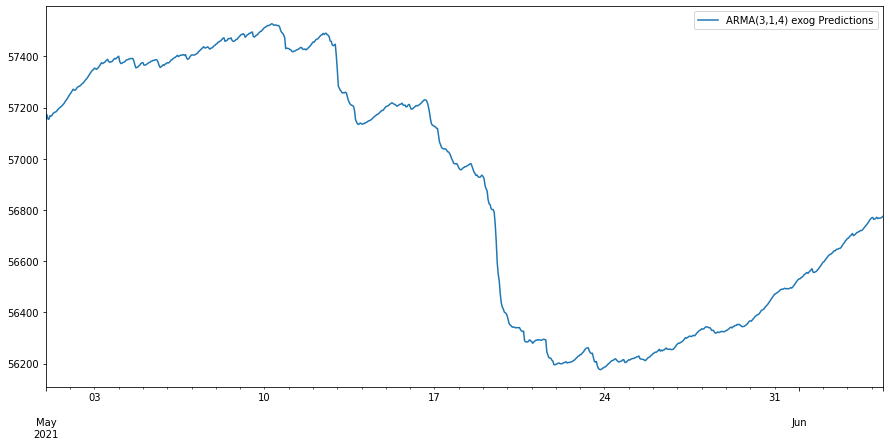

In [81]:

predictions_314_.plot(legend = True)

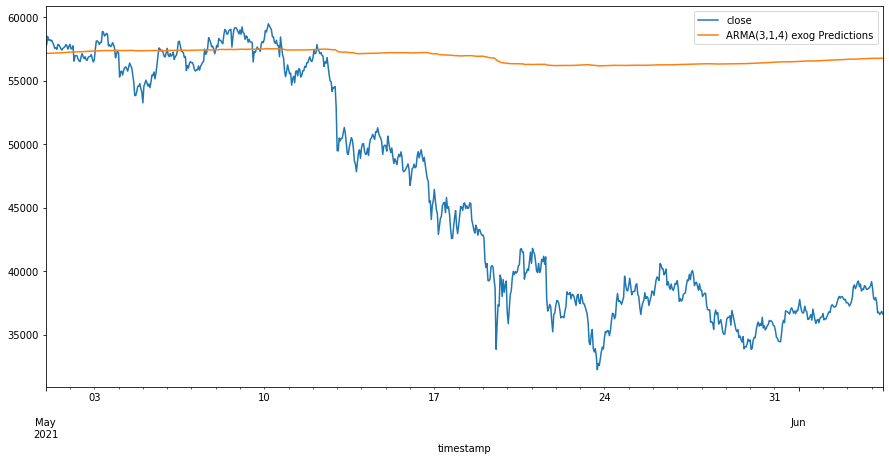

In [82]:
y_test.plot(legend = True)
predictions_314_.plot(legend = True)

### **Our MSE has Reduced from 15002 to 13811 which is 8% deduction in MSE by Including Volume as Exogeneous Variable**